## Mars Photogrammetry Preprocessing Pipeline

By Christian Tate, Cornell University; Ithaca, NY



In [1]:
# Import python modules

import numpy as np
import cv2, glob, time, os
import matplotlib.pyplot as plt
# from planetaryimage import PDS3Image
# import colour_demosaicing
# from PIL import Image
# import matplotlib.cm as cm
# from scipy import interpolate
# from scipy.spatial.transform import Rotation as R
# import colour_demosaicing
import pandas as pd

%run MPPP.py
%matplotlib inline

In [2]:
directory_input = 'Z:/Mastcam-Z/agisoft/data/zcam'



In [21]:
file_extension = ''

'''
future work: save these calibration prameters as a text files, which we load for each camera
'''

# save images and thereby overwrite existing images
save_im    = 1

# add an alpha channel to the output images
save_mask  = 1

# add transparrent pixels to restore the image's full, standard size
pad_im     = 1
pad_im_z   = 1

# turn on when finding the waypoint offsets
find_offsets_mode = 0

# set the color values
gamma      = 2.2      # gamma value
gamma      = 2        # gamma value

# fraction of the dynamic range to clip off the lower values of image 
clip_low_z = 0.02  # for the Mastcam-Z cameras
clip_low   = 0.05  # for everything else


# scale all the scale parameters below bsy the same number
scale_scale = 18

# color balance parameters for the Mars 2020 science cameras
scale_z,  scale_red_z,  scale_blue_z  = [ 0.9*scale_scale, 0.7 , 1.5  ] # Mastcam-Z 
scale_l,  scale_red_l,  scale_blue_l  = [ 1.0*scale_scale, 0.75, 1.40 ] # SuperCam RMI
scale_s,  scale_red_s,  scale_blue_s  = [ 1.0*scale_scale, 0.85, 1.40 ] # SHERLOC WATSON 

# color balance parameters for the Mars 2020 engineering cameras
scale_n,  scale_red_n,  scale_blue_n  = [ 1.0*scale_scale, 0.75, 1.2  ] # Navcam
scale_f,  scale_red_f,  scale_blue_f  = [ 1.1*scale_scale, 0.78, 1.25 ] # Front Hazcam
scale_r,  scale_red_r,  scale_blue_r  = [ 1.1*scale_scale, 0.78, 1.25 ] # Rear Hazcam
scale_v,  scale_red_v,  scale_blue_v  = [ 1.1*scale_scale, 1.12, 0.92 ] # Grayscale VCE Navcam
scale_hr, scale_red_hr, scale_blue_hr = [ 1.0*scale_scale, 0.75, 1.43 ] # Inginuity RTE
scale_hn, scale_red_hn, scale_blue_hn = [ 1.0*scale_scale, 1.1 , 0.92 ] # Inginuity Navcam


In [24]:
# Set input path to IMG files and search criteria

directory_input = 'Z:/Mastcam-Z/agisoft/data/datadrive'
# directory_input = 'Z:/Mastcam-Z/agisoft/data/datadrive/*/ids/rdr/*'
# directory_input = 'Z:/Mastcam-Z/agisoft/data/zcam'

# directory_input = 'C:/Users/cornell/Desktop/data/zcam'
path_input      = directory_input
# path_input      = 'C:/Users/cornell/Desktop/data/*/data/sol/*/rdr/*'  # engineering cameras
# path_input      = 'C:/Users/cornell/Desktop/data/datadrive/*/ids/rdr/*'  # engineering cameras
# path_input    = 'C:/Users/cornell/Desktop/data/*/data/*/rad/*'        # science cameras

# directory_input = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/data/mars2020'
# path_input    = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/data/mars2020/mars2020_*_ops_calibrated/data/sol/00477/ids/rdr/*'  # engineering cameras
# path_input    = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/data/mars2020/mars2020_mastcamz_sci_calibrated/data/*/rad'    # science cameras

# Set output path
directory_output = 'Z:/Mastcam-Z/agisoft/images'
# directory_output = 'C:/Users/cornell/Desktop'
# directory_output = 'Y:/Playground/Simeon/Mars/pds-imaging.jpl.nasa.gov/images' 

pre = '*F_07'
suf = 'refs_700s'

# pre = '*F_06'
# suf = 'refs_ecam_600s'

# pre = '*0_07'
# suf = 'refs_700s'

# pre = 'Z*0_04'
# suf = 'zcam_400s'

# pre = 'S*F_068'
# suf = 'WATSON_sol680s'

# pre = 'Z*0_0'
# suf = 'zcam_refs'

sequ_id = ''

IMG_paths = [] \
          + sorted( glob.glob(  path_input + '/' +pre+'*R*_N*'+sequ_id+'*.IMG' ) ) 

print( len(IMG_paths), 'images\n')
# IMG_paths

78 images



In [25]:
%%time

%run MPPP.py


pos_lines  = []
error_lines= []
rover_xyzs = []
im_xyzs    = []
rover_rots = []
im_azs     = []
im_els     = []
sols       = []
rmcs       = []
ims        = []
im_save_path = ''

print( len(IMG_paths), 'images\n')


for i in range(len(IMG_paths))[::1][:]:
    
#     if 1:
    try:    # catch all the images that fail to process
        
        # open image
        im = image( IMG_paths[i] )
        print( i, im.filename )
        
        # Set color processing parameters
        im.scale       = scale_scale
        im.scale_red   = 1
        im.scale_blue  = 1
        im.clip_low    = clip_low
        im.gamma       = gamma
        im.pad_im      = pad_im
        im.save_im     = save_im
        im.save_mask   = save_mask
        im.find_offsets_mode = find_offsets_mode

        # Mars 2020 Mastcam-Z
        if im.cam[0] == 'Z':
            im.scale       = scale_z
            im.scale_red   = scale_red_z
            im.scale_blue  = scale_blue_z
            im.clip_low    = clip_low_z
            im.pad_im      = pad_im_z

        # Mars 2020 SHERLOC WATSON
        if im.cam[0] == 'S':
            im.scale       = scale_s
            im.scale_red   = scale_red_s
            im.scale_blue  = scale_blue_s
            im.clip_low    = 0.0

        # Mars 2020 SuperCam RMI
        if im.cam[0] == 'L':
            im.scale       = scale_l
            im.scale_red   = scale_red_l
            im.scale_blue  = scale_blue_l

        # Mars 2020 Navcam
        if im.cam[0] == 'N':
            im.scale       = scale_n
            im.scale_red   = scale_red_n
            im.scale_blue  = scale_blue_n

        # Mars 2020 Navcam VCE images
        if 'MV0' in im.IMG_path:
            im.scale       = scale_v
            im.scale_red   = scale_red_v
            im.scale_blue  = scale_blue_v
#             im.clip_low    = 0.15

        # Mars 2020 Front Hazcam
        if im.cam[0] == 'F':
            im.scale       = scale_f
            im.scale_red   = scale_red_f
            im.scale_blue  = scale_blue_f
            im.clip_low    = clip_low/2

        # Mars 2020 Rear Hazcam
        if im.cam[0] == 'R':
            im.scale       = scale_r
            im.scale_red   = scale_red_r
            im.scale_blue  = scale_blue_r
            im.clip_low    = clip_low/2

        # Heli Ingenuity RTE 
        if im.filename[0:3] == 'HSF':
            im.scale       = scale_hr
            im.scale_red   = scale_red_hr
            im.scale_blue  = scale_blue_hr

        # Heli Ingenuity Navcam  
        if im.filename[0:3] == 'HNM':
            im.scale       = scale_hn
            im.scale_red   = scale_red_hn
            im.scale_blue  = scale_blue_hn
        
        # create save directory
        im.save_path_full = make_save_path( im.IMG_path, directory_output, fullpath=True, file_extension = '.png'  ) 
        im.save_path      = make_save_path( im.IMG_path, directory_output, fullpath=False ) 
        im.save_name      = im.save_path_full.split('/')[-1]
        csv_save_path     = im.save_path
        
        # process and save image
        if im.save_im:
            
            im.image_process( )

            if im.save_mask:
                im.im8a = cv2.cvtColor( im.im8, cv2.COLOR_BGR2RGBA )
                im.im8a[:,:,3] = im.mask_im
                cv2.imwrite( im.save_path_full, im.im8a )                
            else:
                cv2.imwrite( im_save_path_full, im.im8[:,:,::-1] )  

        
        # find image position and rotation parameters
        im.image_reference( )

        # save reference data for plotting        
        '''
        future work: replace these lists with pandas dataframes
        '''
        im_xyzs   .append( [ im.X, im.Y, im.Z ] )
        rover_xyzs.append( [ im.X_offset, im.Y_offset, im.Z_offset ] )
        rover_rots.append( im.rot_rover )
        im_azs    .append( im.az )
        im_els    .append( im.el )
        rmcs      .append( im.label['ROVER_MOTION_COUNTER'])
        sols      .append( int(im.label['LOCAL_TRUE_SOLAR_TIME_SOL']) )
        
        # create a line for the reference file
        # Label	 X/East	Y/North	Z/Altitude	Yaw	Pitch	Roll
        pos_line =  im.save_name+'\t'\
                     +str( np.round( im.X,4))+'\t'\
                     +str( np.round( im.Y,4))+'\t'\
                     +str( np.round( im.Z,4))+'\t'\
                     +str( np.round( im.az,2))+'\t'\
                     +str( np.round( im.el,2))+'\t'\
                     +str( np.round( im.rl,2))+'\n'

        pos_lines.append( pos_line )

        try:
            print( 'sol {} site {} drive {}  zenith angle {:0.0f} scale {:0.2f}'.
                        format( im.sol, im.site, im.drive, im.el*57.3, im.ftau ) )
        except:
            print( 'sol {} site {} drive {}'.
                        format( im.sol, im.site, im.drive, ) )
        print( '', i, pos_line[:], )
        print( )

    except:
        print( im.filename, 'failed to process! \n' )
        error_lines.append( im.IMG_path +'\n' )


current_time = time.strftime("%Y%m%d-%H%M%S")


#save failed images list as TXT
if len(error_lines) > 0:
    csv_save_path = im.save_path+'/failed_'+suf+'_'+current_time+'.txt'
    with open(csv_save_path,'w') as file:
        for error_line in error_lines:
            file.write(error_line)

#save image positions as CSV file
csv_save_path = im.save_path+'/positions_'+suf+'_'+current_time+ '.txt'
with open(csv_save_path,'w') as file:
    for pos_line in pos_lines:
        file.write(pos_line)

len( pos_lines )

78 images

0 FLF_0719_0730765498_065RZS_N0343196FHAZ02447_0A0295J01.IMG
sol 719 site 34 drive 3196  zenith angle 3825 scale 0.94
 0 FLF_0719_0730765498_065RZS_N0343196FHAZ02447_0A0295J01.png	-3199.7525	1825.1248	97.1104	275.86	66.76	10


1 FLF_0719_0730778753_898RZS_N0344394FHAZ02418_0A0295J01.IMG
sol 719 site 34 drive 4394  zenith angle 4081 scale 0.74
 1 FLF_0719_0730778753_898RZS_N0344394FHAZ02418_0A0295J01.png	-3411.3674	1837.9083	109.9455	217.68	71.22	10


2 FLF_0721_0730952813_309RZS_N0345120FHAZ02008_0A1095J01.IMG
resizing image size (2880, 5120, 3) by padding = [ left, right, top, bottom ] = [ 0, 0, 960, 0 ]
sol 721 site 34 drive 5120  zenith angle 4130 scale 0.86
 2 FLF_0721_0730952813_309RZS_N0345120FHAZ02008_0A1095J01.png	-3441.3867	1765.9958	113.7554	162.72	72.08	10


3 FRF_0719_0730765498_065RZS_N0343196FHAZ02447_0A0295J01.IMG
sol 719 site 34 drive 3196  zenith angle 3710 scale 0.94
 3 FRF_0719_0730765498_065RZS_N0343196FHAZ02447_0A0295J01.png	-3199.6558	1825.3532	97.0879	

sol 721 site 34 drive 5120  zenith angle 3434 scale 0.85
 31 NLF_0721_0730953341_902RZS_N0345120NCAM03721_0A0185J02.png	-3442.1556	1766.1247	114.8434	239.8	59.92	0


32 NLF_0721_0730953490_245RZS_N0345120NCAM03721_0A0185J01.IMG
sol 721 site 34 drive 5120  zenith angle 3432 scale 0.84
 32 NLF_0721_0730953490_245RZS_N0345120NCAM03721_0A0185J01.png	-3442.365	1766.3138	114.8111	311.83	59.9	0


33 NLF_0721_0730953747_507RZS_N0345120NCAM02721_0A0185J01.IMG
sol 721 site 34 drive 5120  zenith angle 3444 scale 0.83
 33 NLF_0721_0730953747_507RZS_N0345120NCAM02721_0A0185J01.png	-3442.2677	1766.5801	114.7793	23.99	60.11	0


34 NLF_0721_0730953894_120RZS_N0345120NCAM02721_0A0185J01.IMG
sol 721 site 34 drive 5120  zenith angle 3430 scale 0.83
 34 NLF_0721_0730953894_120RZS_N0345120NCAM02721_0A0185J01.png	-3441.9661	1766.5821	114.7906	95.68	59.87	0


35 NLF_0721_0730956964_909RZS_N0345120NCAM15721_0A0195J02.IMG
resizing image size (960, 2560, 3) by padding = [ left, right, top, bottom ] = [ 0, 0, 0,

sol 719 site 34 drive 4394  zenith angle 4361 scale 0.57
 60 NRF_0719_0730782216_397RZS_N0344394NCAM04719_0A0195J01.png	-3411.6549	1838.5274	111.0724	170.97	76.11	0


61 NRF_0719_0730782385_320RZS_N0344394NCAM04719_0A0195J01.IMG
resizing image size (960, 2560, 3) by padding = [ left, right, top, bottom ] = [ 0, 0, 0, 960 ]
sol 719 site 34 drive 4394  zenith angle 4348 scale 0.56
 61 NRF_0719_0730782385_320RZS_N0344394NCAM04719_0A0195J01.png	-3411.6859	1838.8314	111.0374	243.14	75.88	0


62 NRF_0719_0730782517_678RZS_N0344394NCAM02719_0A0195J01.IMG
sol 719 site 34 drive 4394  zenith angle 3456 scale 0.55
 62 NRF_0719_0730782517_678RZS_N0344394NCAM02719_0A0195J01.png	-3411.2414	1838.8015	111.0252	9.16	60.31	0


63 NRF_0719_0730782787_448RZS_N0344394NCAM02719_0A0195J01.IMG
sol 719 site 34 drive 4394  zenith angle 3447 scale 0.54
 63 NRF_0719_0730782787_448RZS_N0344394NCAM02719_0A0195J01.png	-3411.2889	1838.5237	111.0515	81.33	60.15	0


64 NRF_0721_0730952605_411RZS_N0345120NCAM00709_0A009

76

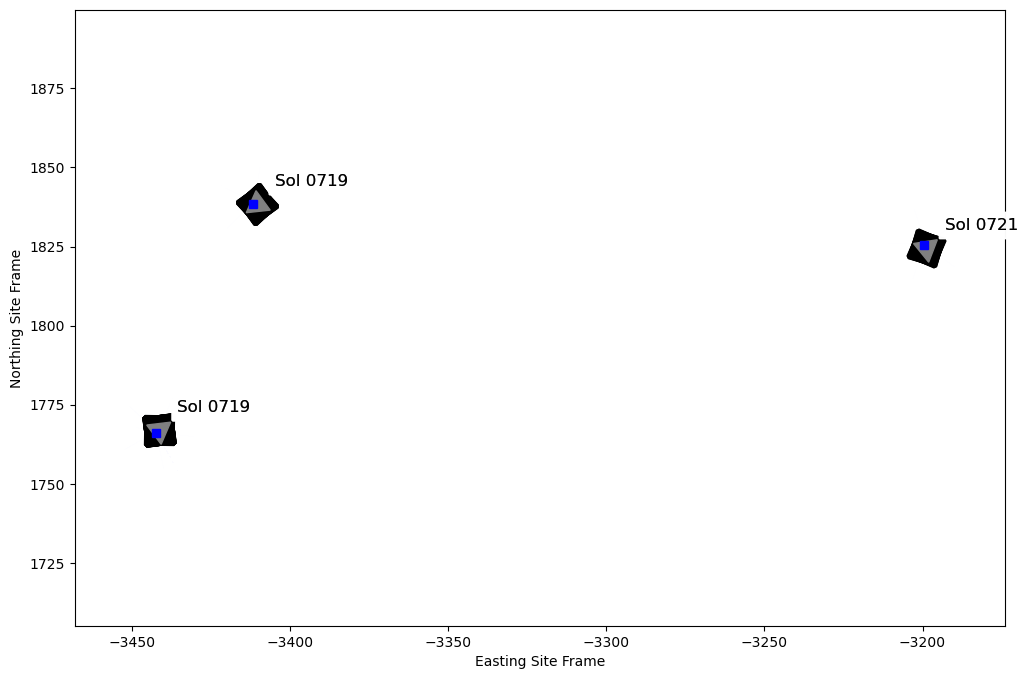

In [6]:
%run MPPP.py

# plot image and rover locations

plot_image_locations( IMG_paths, im_xyzs, rover_xyzs, rover_rots, im_azs, im_els )

## Ignore the notes below

In [7]:
# '''
# df_refs : pandas dataframe that holds reference info for each image

# data saves in the output directory as a CSV file 'df'+output+'.csv' and as a python pickle 'df'+output+'.pkl'

# '''

# df_refs = pd.DataFrame( 
#     columns = [ 
#         'sol',           # sol number or Mars day since landing is a natural way to describe images.
#         'site',          # site index for the rover's location, site 3 is the landing site
#         'drive',         # drive index is where the rover is relative to the current site frame
#         'time',          # datetime of image capture
        
#         'xyz_enu',       # postition XYZ values in meters ENU = [xEast, yNorth, zUp ] from site 3 (note: as Metashape interprets XYZ)
#         'xyz_ned',       # postition XYZ values in meters NED = [xNorth, yEast, zDown] from site 3
#         'rot_rpy',       # rotation angles in RPY = [roll, pitch, yaw] in degrees (as Metashape interprets roll-pitch-yaw)
#         'rot_ypr',       # rotation angles in YPR = [yaw, pitch, roll] in degrees 
#         'rot_opk',       # rotation angles in OPK = [omega, phi, kappa] in degrees 
        
#         'site_wy',       # waypoint site index, same as the current site if 'site_wy' == 'site' 
#         'drive_wp',      # waypoint drive index, same as the current drive if 'drive_wy' == 'drive'      
#         'xyz_wp',        # waypoint postition XYZ values in meters NED = [xNorthing, yEasting, zElevation]
#         'xyz_site3'      # postition of site3 (OEB landing site) in meters NED = [xNorth, yEast, zDown], 'xyz_site3'=[0,0,0] if site3 is the default reference frame
#         'nee_site3'      # postition of site3 (OEB landing site) in meters NED = [xNorthing, yEasting, zElevation]
#         'lle_site3'      # postition in [longitude, latitude, elevation] Mars global coordinates        
       
#         'cahvor',        # the CAHVOR or CAHVORE camera model in rover frame [xFront, yRight, zDown]
#         'az_site',       # site-frame azimuth pointing in degrees clockwise from the North vector 
#         'el_site',       # site-frame elevation pointing in degrees positive from the horizone
#         'az_rover',      # rover-frame azimuth pointing in degrees clockwise from the rover's forward vector
#         'el_rover',      # rover-frame elevation pointing in degrees positive from the forward-right plane       
        
#         'ref',           # string that forms the image's line in the reference file for import to software (Metashape)
#         'filename',      # file name with .IMG extension
#         'filepath',      # complete file path to image at run time
# ])


# df_refs

In [8]:
# ignore the below cells

In [9]:
# For find_offset_mode = 1

# # pos_lines  = []
# # rover_xyzs = []
# # im_xyzs    = []
# # sols       = []
# # rmcs = []
sites  = [ rmcs[i][0] for i in range(len(rmcs))[::-1] ]
drives = [ rmcs[i][1] for i in range(len(rmcs))[::-1] ]
Xs     = [ rover_xyzs[i][0] for i in range(len(rover_xyzs))[::-1] ]
Ys     = [ rover_xyzs[i][1] for i in range(len(rover_xyzs))[::-1] ]
Zs     = [ rover_xyzs[i][2] for i in range(len(rover_xyzs))[::-1] ]

table = np.stack( [sols[::-1], sites, drives, Xs, Ys, Zs], axis=1)
np.round( table, 4 )

np.savetxt( directory_output+"/offsets.csv", table, delimiter="\t")

In [10]:
# Scam flatfield

path = 'C:/Users/cornell/Mastcam-Z/ws/seitah'
pre = 'L*_0510*'

RAD_paths = [] \
          + sorted( glob.glob(  path + '/' +pre+'*R*_N*.IMG' ) ) \

RAD_paths

ims = []
for i in range(len(RAD_paths))[:]:
    
    im_image = PDS3Image.open( RAD_paths[i] ).image
    ims.append( np.float64( im_image) )
    
flat = np.mean( ims, axis=0)
for i in range(3):
    flat[:,:,i] /= np.mean( flat[700:-700,700:-700,i] )
    
plt.imshow( flat/1.5 )

C:\Users\cdt59\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\cdt59\Anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


IndexError: invalid index to scalar variable.

In [ ]:
x = np.arange(0, 2048)
y = np.arange(0, 2048)
xv, yv = np.meshgrid(x, y)

y0, x0, r0, p = [900,1000,1000,3]
dv = ( (xv-x0)**2 + (yv-y0)**2 )**(p/2)
dv /= (r0**p)*2
dv += 1

# lim = .8
# dv[ dv<lim]  =lim

dflat = flat.copy()
for i in range(3):
    dflat[:,:,i] *= dv
    
plt.imshow( dflat/2 )
plt.colorbar()

In [ ]:
dvl = np.mean( dflat[:,1000:1300], axis=1)
plt.plot(dvl)

dvl = np.mean( flat[:,1000:1300], axis=1)
plt.plot(dvl)
# flat = dflat.copy()

In [ ]:
import urllib.request, json 

'''

https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json

https://docs.google.com/spreadsheets/d/1GSNJL-e5iROCaKUC4BXL_OA8hWy8vUdfCN7levRNkZA/edit#gid=1232397498

''' 
# path =  'C:/Users/cornell/Downloads/M20_waypoints.json'
# with open( path ) as f:
#     data = json.load(f)

with urllib.request.urlopen("https://mars.nasa.gov/mmgis-maps/M20/Layers/json/M20_waypoints.json") as url:
    data = json.loads(url.read().decode())

    
site3_E = data['features'][0]['properties']['easting']
site3_N = data['features'][0]['properties']['northing']
site3_A = data['features'][0]['properties']['elev_geoid']


for i in range(len(data['features']))[::-1]:
    
    print( data['features'][i]['properties']['sol'],'\t',
           data['features'][i]['properties']['site'], '\t',
           data['features'][i]['properties']['drive'],'\t',
           ''+'\t',''+'\t',''+'\t',
           np.round( np.float64(data['features'][i]['properties']['easting'])- np.float64(site3_E), 3),'\t',
           np.round( np.float64(data['features'][i]['properties']['northing'])- np.float64(site3_N), 3),'\t',
           np.round( np.float64(data['features'][i]['properties']['elev_geoid'])- np.float64(site3_A), 3),'\t',
         )